## Import Libraries


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, LeakyReLU, Dropout, Dense, ReLU, Bidirectional, BatchNormalization
from tensorflow.keras import regularizers

from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from termcolor import colored
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import keras

In [ ]:
import warnings

warnings.filterwarnings('ignore')

## Load the Data

In [ ]:
GOOGL = pd.read_csv("GOOGL.csv")
INTC = pd.read_csv("INTC.csv")

GOOGL Data

In [ ]:
GOOGL.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659000
1,2004-08-20,50.555557,54.594593,50.300301,54.209209,54.209209,22834300
2,2004-08-23,55.430431,56.796795,54.579578,54.754753,54.754753,18256100
3,2004-08-24,55.675674,55.855854,51.836838,52.487488,52.487488,15247300
4,2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188600


INTC data

In [ ]:
INTC.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-03-17,0.325521,0.330729,0.325521,0.325521,0.204750,10924800
1,1980-03-18,0.325521,0.328125,0.322917,0.322917,0.203112,17068800
2,1980-03-19,0.330729,0.335938,0.330729,0.330729,0.208026,18508800
3,1980-03-20,0.330729,0.334635,0.329427,0.329427,0.207207,11174400
4,1980-03-21,0.322917,0.322917,0.317708,0.317708,0.199836,12172800


## Exploration

### Tipe data setiap variabel 

In [ ]:
GOOGL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3932 entries, 0 to 3931
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3932 non-null   object 
 1   Open       3932 non-null   float64
 2   High       3932 non-null   float64
 3   Low        3932 non-null   float64
 4   Close      3932 non-null   float64
 5   Adj Close  3932 non-null   float64
 6   Volume     3932 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 215.2+ KB


In [ ]:
INTC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10098 entries, 0 to 10097
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10098 non-null  object 
 1   Open       10098 non-null  float64
 2   High       10098 non-null  float64
 3   Low        10098 non-null  float64
 4   Close      10098 non-null  float64
 5   Adj Close  10098 non-null  float64
 6   Volume     10098 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 552.4+ KB


### Data tidak memiliki nilai null

In [ ]:
GOOGL.isna().sum() + INTC.isna().sum() 

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### Data GOOGL dari 20 Agustus 2004 sampai 1 April 2020

In [ ]:
GOOGL.loc[GOOGL.index[1], 'Date'], GOOGL.loc[GOOGL.index[-1], 'Date']

('2004-08-20', '2020-04-01')

### Data INTC dari 18 Maret 1980 sampai 1 April 2020

In [ ]:
INTC.loc[INTC.index[1], 'Date'], INTC.loc[INTC.index[-1], 'Date']

('1980-03-18', '2020-04-01')

### Histogram 

Distribusi variabel close bukan merupakan distribusi normal, melainkan skewed

Text(0.5, 1.0, 'INTC Histogram')

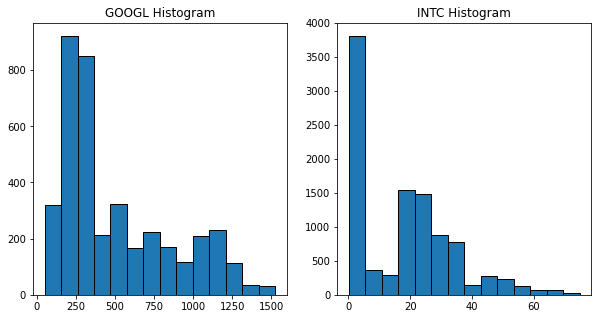

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].hist(GOOGL['Close'], bins=14, edgecolor='black')
ax[0].set_title("GOOGL Histogram")
ax[1].hist(INTC['Close'], bins=14, edgecolor='black')
ax[1].set_title("INTC Histogram")

### Boxplot

Boxplot menunjukan bahwa data GOOGL tidak memiliki outlier, sedangkan INTC memiliki beberapa outlier

Text(0.5, 1.0, 'INTC boxplot')

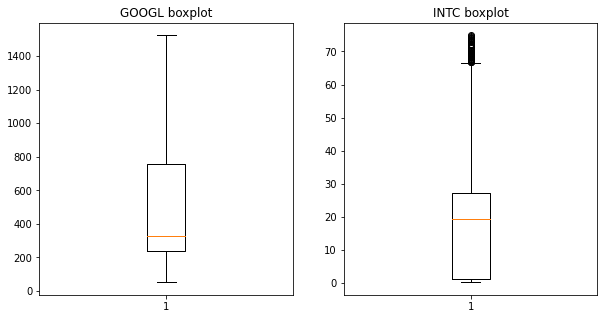

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].boxplot(GOOGL['Close'])
ax[0].set_title("GOOGL boxplot")
ax[1].boxplot(INTC['Close'])
ax[1].set_title("INTC boxplot")

### Data yang digunakan untuk membangun LSTM adalah Close sesuai spesifikasi soal

In [ ]:
GOOGL_close = GOOGL[["Date", "Close"]]
INTC_close = INTC[["Date", "Close"]]

GOOGL_close.head(3)

,Date,Close
0,2004-08-19,50.220219
1,2004-08-20,54.209209
2,2004-08-23,54.754753


### Konversi kolom data Date ke datatype yang benar

In [ ]:
GOOGL_close["Date"] = pd.to_datetime(GOOGL_close["Date"])
INTC_close["Date"] = pd.to_datetime(INTC_close["Date"])

### Set Fitur Date menjadi index

In [ ]:
GOOGL_close = GOOGL_close.set_index('Date')[["Close"]]
INTC_close = INTC_close.set_index('Date')[["Close"]]

In [ ]:
full_date_range = pd.date_range(start=GOOGL_close.index.min(), end=GOOGL_close.index.max(), freq='D')
GOOGL_reindexed = GOOGL_close.reindex(full_date_range)

missing_dates = GOOGL_reindexed[GOOGL_reindexed['Close'].isna()].index

print("Missing Dates:")
print(missing_dates)
print("Missing Count", len(missing_dates))

Missing Dates:
DatetimeIndex(['2004-08-21', '2004-08-22', '2004-08-28', '2004-08-29',
               '2004-09-04', '2004-09-05', '2004-09-06', '2004-09-11',
               '2004-09-12', '2004-09-18',
               ...
               '2020-02-29', '2020-03-01', '2020-03-07', '2020-03-08',
               '2020-03-14', '2020-03-15', '2020-03-21', '2020-03-22',
               '2020-03-28', '2020-03-29'],
              dtype='datetime64[ns]', length=1773, freq=None)
Missing Count 1773


### Line Plot

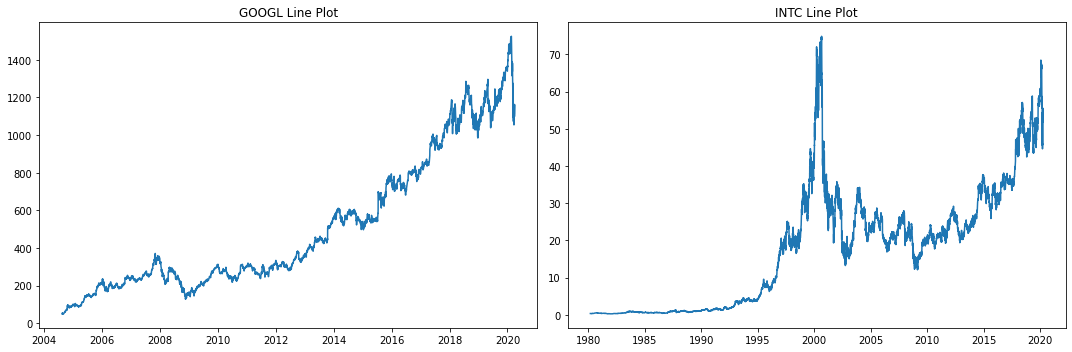

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
ax[0].plot(GOOGL_close.index, GOOGL_close['Close'], linestyle='-')
ax[0].set_title("GOOGL Line Plot")
ax[1].plot(INTC_close.index, INTC_close['Close'], linestyle='-')
ax[1].set_title("INTC Line Plot")
plt.tight_layout()


### Line Plot untuk setiap hari dalam minggu

Tidak terdapat data dari hari Sabtu dan Minggu

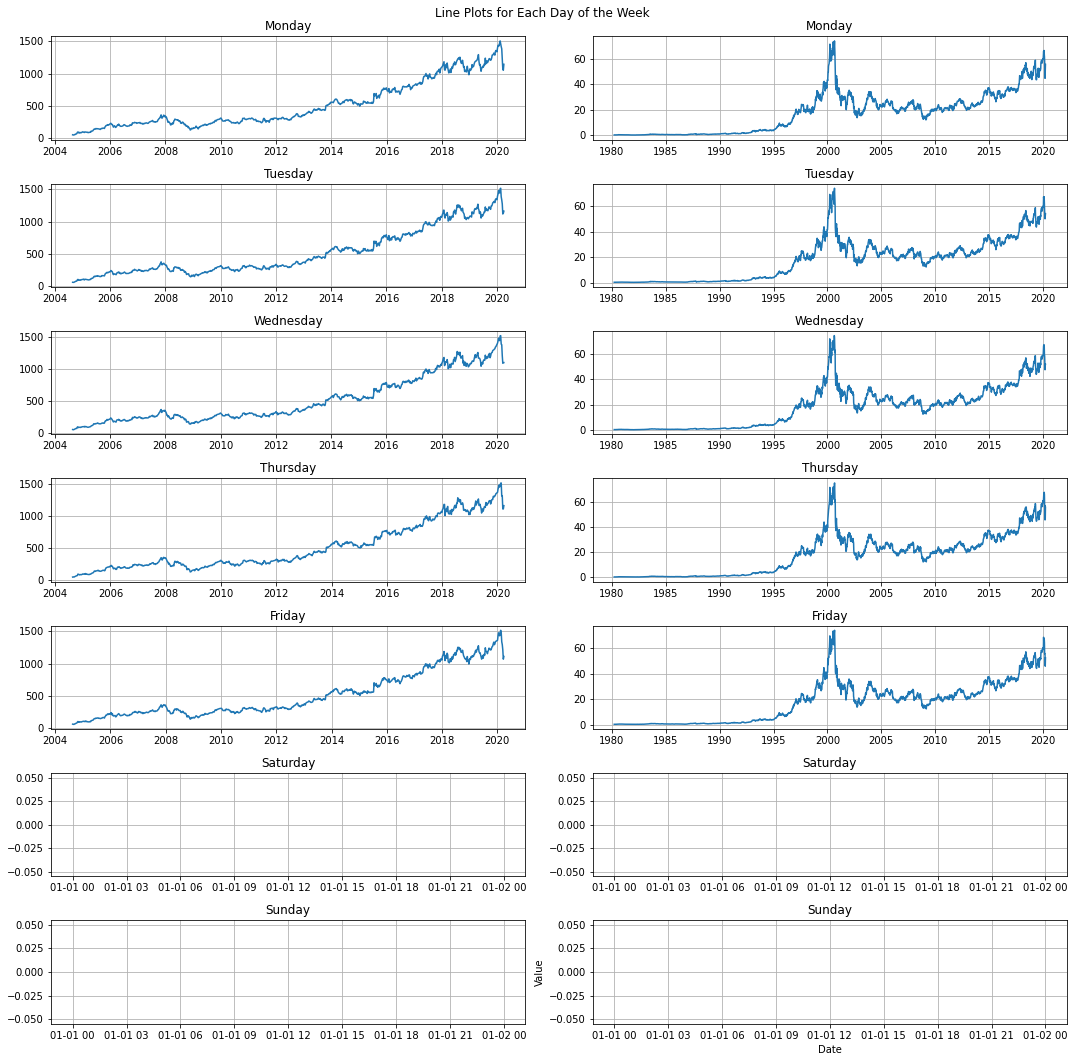

In [94]:
data_days_GOOGL = GOOGL_close.index.day_name()
data_days_INTC =  INTC_close.index.day_name()

fig, axes = plt.subplots(7, 2, figsize=(15, 15))

days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for i, day in enumerate(days_of_week):
    daily_data_GOOGL  = GOOGL_close[data_days_GOOGL == day]
    axes[i][0].plot(daily_data_GOOGL .index, daily_data_GOOGL ['Close'], linestyle='-', label=day)
    axes[i][0].set_title(day)
    axes[i][0].grid(True)

for j, day in enumerate(days_of_week):
    daily_data_INTC  = INTC_close[data_days_INTC == day]
    axes[j][1].plot(daily_data_INTC.index, daily_data_INTC ['Close'], linestyle='-', label=day)
    axes[j][1].set_title(day)
    axes[j][1].grid(True)

plt.xlabel('Date')
plt.ylabel('Value')
plt.suptitle('Line Plots for Each Day of the Week')
plt.tight_layout()
plt.show()

## Preprocessing

### Split Train and Test

Split menjadi train, test, dan validation 

In [95]:
def split_data(data):
    train_size = int(0.8 * len(data))
    val_size = int(0.1 * len(data))
    train, val, test = data[:train_size], data[train_size:train_size+val_size], data[train_size+val_size:]
    return train, val, test

GOOGL_train, GOOGL_val, GOOGL_test = split_data(GOOGL_close)
INTC_train, INTC_val, INTC_test = split_data(INTC_close)

In [96]:
GOOGL_train.shape, GOOGL_val.shape, GOOGL_test.shape

((3145, 1), (393, 1), (394, 1))

### Apply Scaling

Lakukan scaling data sehingga model dapat belajar dengan lebih baik.

In [97]:
MMS_GOOGL = MinMaxScaler(feature_range=(0, 1))
MMS_INTC = MinMaxScaler(feature_range=(0, 1))

GOOGL_train = MMS_GOOGL.fit_transform(GOOGL_train)
GOOGL_val = MMS_GOOGL.transform(GOOGL_val)
GOOGL_test = MMS_GOOGL.transform(GOOGL_test)

INTC_train = MMS_INTC.fit_transform(INTC_train)
INTC_val = MMS_INTC.transform(INTC_val)
INTC_test = MMS_INTC.transform(INTC_test)


### Create the Input and Output using windows

In [98]:
def create_input_output_pairs(data, window_size, horizon):
    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size + horizon - 1])
    return np.array(X), np.array(y)

window_size = 5
horizon = 1

GOOGL_xtrain, GOOGL_ytrain = create_input_output_pairs(GOOGL_train, window_size, horizon)
GOOGL_xtest, GOOGL_ytest = create_input_output_pairs(GOOGL_test, window_size, horizon)
GOOGL_xval, GOOGL_yval = create_input_output_pairs(GOOGL_val, window_size, horizon)

INTC_xtrain, INTC_ytrain = create_input_output_pairs(np.array(INTC_train), window_size, horizon)
INTC_xval, INTC_yval = create_input_output_pairs(np.array(INTC_val), window_size, horizon)
INTC_xtest, INTC_ytest = create_input_output_pairs(np.array(INTC_test), window_size, horizon)

print(GOOGL_xtrain.shape, GOOGL_ytrain.shape)
print(GOOGL_xtest.shape, GOOGL_ytest.shape)
print(GOOGL_xval.shape, GOOGL_yval.shape)

print(INTC_xtrain.shape, INTC_ytrain.shape)
print(INTC_xtest.shape, INTC_ytest.shape)
print(INTC_xval.shape, INTC_yval.shape)

(3140, 5, 1) (3140, 1)
(389, 5, 1) (389, 1)
(388, 5, 1) (388, 1)
(8073, 5, 1) (8073, 1)
(1006, 5, 1) (1006, 1)
(1004, 5, 1) (1004, 1)


## Modelling

### Define Functions

In [99]:
def compiler(model, xtrain, ytrain, xval, yval, epochs):
    model.compile(loss='mse', optimizer= Adam(learning_rate=0.0001),metrics='mse')
    model_history = model.fit(xtrain, ytrain, epochs=epochs,validation_data=(xval, yval), shuffle=False)
    train_loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']
    return train_loss, val_loss

In [124]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def get_evaluation(model, xtest, ytest, scaler):
    ypred = model.predict(xtest)

    ypred = scaler.inverse_transform(ypred)
    ytest_inverse_transformed = scaler.inverse_transform(ytest)


    rmse = np.sqrt(mean_squared_error(ytest_inverse_transformed, ypred))
    mae = mean_absolute_error(ytest_inverse_transformed, ypred)
    mape = np.mean(np.abs((ytest_inverse_transformed - ypred) / ytest_inverse_transformed)) * 100

    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"MAPE: {mape}")

#### Creating the Base Models

Base model adalah model dengan 50 unit LSTM dengan 1 perceptron sebagai output

In [112]:
model_base_GOOGL = Sequential()
model_base_GOOGL.add(LSTM(50, activation='relu', input_shape=(window_size, 1), return_sequences=False))
model_base_GOOGL.add(Dense(1))

loss_model_base_GOOGL = compiler(model_base_GOOGL, GOOGL_xtrain, GOOGL_ytrain, GOOGL_xval, GOOGL_yval, 40)

Epoch 1/40
99/99 [==============================] - 1s 4ms/step - loss: 0.1600 - mse: 0.1600 - val_loss: 1.1215 - val_mse: 1.1215
Epoch 2/40
99/99 [==============================] - 0s 2ms/step - loss: 0.1142 - mse: 0.1142 - val_loss: 0.9010 - val_mse: 0.9010
Epoch 3/40
99/99 [==============================] - 0s 2ms/step - loss: 0.0824 - mse: 0.0824 - val_loss: 0.6999 - val_mse: 0.6999
Epoch 4/40
99/99 [==============================] - 0s 2ms/step - loss: 0.0556 - mse: 0.0556 - val_loss: 0.5072 - val_mse: 0.5072
Epoch 5/40
99/99 [==============================] - 0s 3ms/step - loss: 0.0346 - mse: 0.0346 - val_loss: 0.3331 - val_mse: 0.3331
Epoch 6/40
99/99 [==============================] - 0s 2ms/step - loss: 0.0210 - mse: 0.0210 - val_loss: 0.1969 - val_mse: 0.1969
Epoch 7/40
99/99 [==============================] - 0s 2ms/step - loss: 0.0142 - mse: 0.0142 - val_loss: 0.1070 - val_mse: 0.1070
Epoch 8/40
99/99 [==============================] - 0s 2ms/step - loss: 0.0107 - mse: 0.01

In [ ]:
model_base_INTC = Sequential()
model_base_INTC.add(LSTM(50, activation='relu', input_shape=(window_size, 1), return_sequences=False))
model_base_INTC.add(Dense(1))

loss_model_base_INTC = compiler(model_base_INTC, INTC_xtrain, INTC_ytrain, INTC_xval, INTC_yval, 40)

Epoch 1/40
253/253 [==============================] - 2s 3ms/step - loss: 0.0229 - mse: 0.0229 - val_loss: 0.0260 - val_mse: 0.0260
Epoch 2/40
253/253 [==============================] - 1s 2ms/step - loss: 0.0156 - mse: 0.0156 - val_loss: 0.0109 - val_mse: 0.0109
Epoch 3/40
253/253 [==============================] - 1s 2ms/step - loss: 0.0109 - mse: 0.0109 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 4/40
253/253 [==============================] - 1s 2ms/step - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 5/40
253/253 [==============================] - 1s 2ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 4.8656e-04 - val_mse: 4.8656e-04
Epoch 6/40
253/253 [==============================] - 1s 2ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 1.4184e-04 - val_mse: 1.4184e-04
Epoch 7/40
253/253 [==============================] - 1s 2ms/step - loss: 5.0185e-04 - mse: 5.0185e-04 - val_loss: 6.9844e-05 - val_mse: 6.9844e-05
Epoch 8/40
253/253 [========================

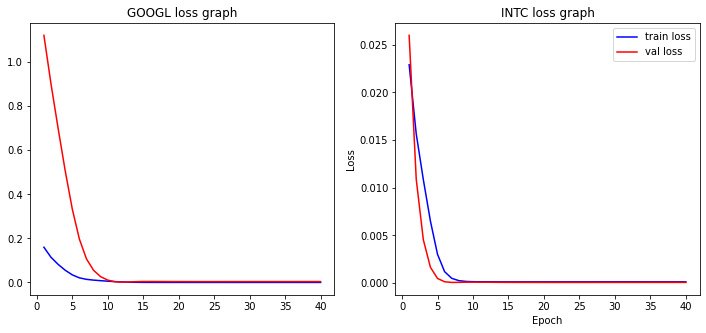

In [113]:
epochs = range(1, len(loss_model_base_GOOGL[0]) + 1)
fig, ax = plt.subplots(1, 2, figsize = (12,5))
ax[0].plot(epochs, loss_model_base_GOOGL[0], 'b', label = 'train loss')
ax[0].plot(epochs, loss_model_base_GOOGL[1], 'r', label = 'val loss')
ax[0].set_title("GOOGL loss graph")

ax[1].plot(epochs, loss_model_base_INTC[0], 'b', label = 'train loss')
ax[1].plot(epochs, loss_model_base_INTC[1], 'r', label = 'val loss')
ax[1].set_title("INTC loss graph")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


32/32 [==============================] - 0s 1ms/step


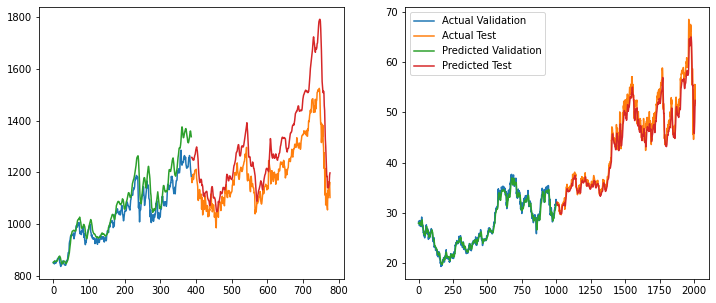

In [115]:
valprediction_GOOGL = MMS_GOOGL.inverse_transform(model_base_GOOGL.predict(GOOGL_xval))
testprediction_GOOGL = MMS_GOOGL.inverse_transform(model_base_GOOGL.predict(GOOGL_xtest))

valprediction_INTC = MMS_INTC.inverse_transform(model_base_INTC.predict(INTC_xval))
testprediction_INTC = MMS_INTC.inverse_transform(model_base_INTC.predict(INTC_xtest))

fig, ax = plt.subplots(1, 2, figsize = (12,5))

ax[0].plot(range(0, len(GOOGL_yval)),  MMS_GOOGL.inverse_transform(GOOGL_yval), label = "Actual Validation")
ax[0].plot(range(len(GOOGL_yval), len(GOOGL_yval) + len(GOOGL_ytest)), MMS_GOOGL.inverse_transform(GOOGL_ytest), label = 'Actual Test')
ax[0].plot(range(0, len(GOOGL_yval)),  valprediction_GOOGL, label = "Predicted Validation")
ax[0].plot(range(len(GOOGL_yval), len(GOOGL_yval) + len(GOOGL_ytest)), testprediction_GOOGL, label = 'Predicted Test')

ax[1].plot(range(0, len(INTC_yval)),  MMS_INTC.inverse_transform(INTC_yval), label = "Actual Validation")
ax[1].plot(range(len(INTC_yval), len(INTC_yval) + len(INTC_ytest)), MMS_INTC.inverse_transform(INTC_ytest), label = 'Actual Test')
ax[1].plot(range(0, len(INTC_yval)),  valprediction_INTC, label = "Predicted Validation")
ax[1].plot(range(len(INTC_yval), len(INTC_yval) + len(INTC_ytest)), testprediction_INTC, label = 'Predicted Test')

plt.legend()



In [125]:
get_evaluation(model_base_GOOGL, GOOGL_xtest, GOOGL_ytest, MMS_GOOGL)

13/13 [==============================] - 0s 1ms/step
RMSE: 114.57774950205217
MAE: 94.52280173019763
MAPE: 7.605177357828516


In [126]:
get_evaluation(model_base_INTC, INTC_xtest, INTC_ytest, MMS_INTC)


32/32 [==============================] - 0s 1ms/step
RMSE: 1.6459654487605329
MAE: 1.2449538968429397
MAPE: 2.6129490518436675


### Modified Models

Model di modifikasi dengan menggunakan Bidirectional LSTM dan juga menambahkan dropout sehingga mengurangi overfitting

Bidirectional LSTM memiliki lebih banyak parameter dibandingkan dengan LSTM biasa karena memproses data dalam dua arah (maju dan mundur). Kompleksitas yang lebih tinggi dapat membantu model belajar lebih banyak.

In [ ]:
model_modified_GOOGL = Sequential()
model_modified_GOOGL.add(Bidirectional(LSTM(50, return_sequences=True, activation = 'tanh'), input_shape=(window_size, 1)))
model_modified_GOOGL.add(Dropout(0.2))
model_modified_GOOGL.add(Bidirectional(LSTM(50, return_sequences=False, activation = 'tanh')))
model_modified_GOOGL.add(Dropout(0.1))

model_modified_GOOGL.add(Dense(1))

loss_model_modified_GOOGL = compiler(model_modified_GOOGL, GOOGL_xtrain, GOOGL_ytrain, GOOGL_xval, GOOGL_yval, 40)

Epoch 1/40
99/99 [==============================] - 6s 17ms/step - loss: 0.0137 - mse: 0.0137 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 2/40
99/99 [==============================] - 1s 5ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 3/40
99/99 [==============================] - 1s 5ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 4/40
99/99 [==============================] - 1s 5ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 5/40
99/99 [==============================] - 1s 5ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 7.5096e-04 - val_mse: 7.5096e-04
Epoch 6/40
99/99 [==============================] - 1s 5ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0010 - val_mse: 0.0010
Epoch 7/40
99/99 [==============================] - 1s 6ms/step - loss: 8.8420e-04 - mse: 8.8420e-04 - val_loss: 7.9313e-04 - val_mse: 7.9313e-04
Epoch 8/40
99/99 [==============================] - 1s 5ms/step -

In [ ]:
model_modified_INTC = Sequential()
model_modified_INTC.add(Bidirectional(LSTM(50, return_sequences=True, activation = 'tanh'), input_shape=(window_size, 1)))
model_modified_INTC.add(Bidirectional(LSTM(50, return_sequences=False, activation = 'tanh')))

model_modified_INTC.add(Dense(1))

loss_model_modified_INTC = compiler(model_modified_INTC, INTC_xtrain, INTC_ytrain, INTC_xval, INTC_yval, 40)

Epoch 1/40
253/253 [==============================] - 8s 10ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 2/40
253/253 [==============================] - 1s 5ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 6.8754e-04 - val_mse: 6.8754e-04
Epoch 3/40
253/253 [==============================] - 1s 5ms/step - loss: 4.3535e-04 - mse: 4.3535e-04 - val_loss: 1.9924e-04 - val_mse: 1.9924e-04
Epoch 4/40
253/253 [==============================] - 1s 5ms/step - loss: 2.0467e-04 - mse: 2.0467e-04 - val_loss: 9.5444e-05 - val_mse: 9.5444e-05
Epoch 5/40
253/253 [==============================] - 1s 5ms/step - loss: 1.4835e-04 - mse: 1.4835e-04 - val_loss: 7.5944e-05 - val_mse: 7.5944e-05
Epoch 6/40
253/253 [==============================] - 1s 5ms/step - loss: 1.3483e-04 - mse: 1.3483e-04 - val_loss: 7.1254e-05 - val_mse: 7.1254e-05
Epoch 7/40
253/253 [==============================] - 1s 5ms/step - loss: 1.3157e-04 - mse: 1.3157e-04 - val_loss: 7.0159e-05 - val_mse

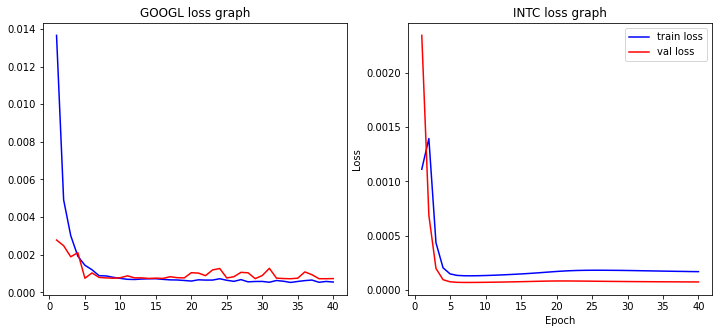

In [ ]:
epochs = range(1, len(loss_model_modified_GOOGL[0]) + 1)
fig, ax = plt.subplots(1, 2, figsize = (12,5))
ax[0].plot(epochs, loss_model_modified_GOOGL[0], 'b', label = 'train loss')
ax[0].plot(epochs, loss_model_modified_GOOGL[1], 'r', label = 'val loss')
ax[0].set_title("GOOGL loss graph")

ax[1].plot(epochs, loss_model_modified_INTC[0], 'b', label = 'train loss')
ax[1].plot(epochs, loss_model_modified_INTC[1], 'r', label = 'val loss')
ax[1].set_title("INTC loss graph")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


32/32 [==============================] - 0s 2ms/step


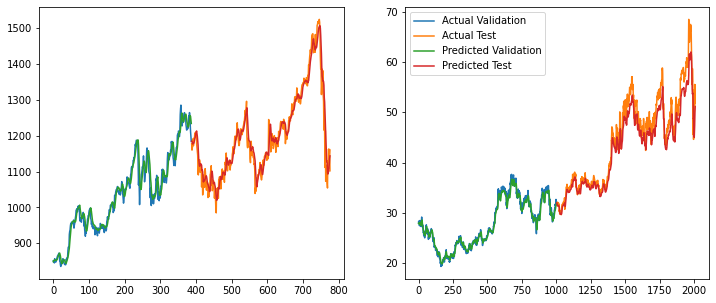

In [123]:
valprediction_GOOGL = MMS_GOOGL.inverse_transform(model_modified_GOOGL.predict(GOOGL_xval))
testprediction_GOOGL = MMS_GOOGL.inverse_transform(model_modified_GOOGL.predict(GOOGL_xtest))

valprediction_INTC = MMS_INTC.inverse_transform(model_modified_INTC.predict(INTC_xval))
testprediction_INTC = MMS_INTC.inverse_transform(model_modified_INTC.predict(INTC_xtest))

fig, ax = plt.subplots(1, 2, figsize = (12,5))

ax[0].plot(range(0, len(GOOGL_yval)),  MMS_GOOGL.inverse_transform(GOOGL_yval), label = "Actual Validation")
ax[0].plot(range(len(GOOGL_yval), len(GOOGL_yval) + len(GOOGL_ytest)), MMS_GOOGL.inverse_transform(GOOGL_ytest), label = 'Actual Test')
ax[0].plot(range(0, len(GOOGL_yval)),  valprediction_GOOGL, label = "Predicted Validation")
ax[0].plot(range(len(GOOGL_yval), len(GOOGL_yval) + len(GOOGL_ytest)), testprediction_GOOGL, label = 'Predicted Test')

ax[1].plot(range(0, len(INTC_yval)),  MMS_INTC.inverse_transform(INTC_yval), label = "Actual Validation")
ax[1].plot(range(len(INTC_yval), len(INTC_yval) + len(INTC_ytest)), MMS_INTC.inverse_transform(INTC_ytest), label = 'Actual Test')
ax[1].plot(range(0, len(INTC_yval)),  valprediction_INTC, label = "Predicted Validation")
ax[1].plot(range(len(INTC_yval), len(INTC_yval) + len(INTC_ytest)), testprediction_INTC, label = 'Predicted Test')

plt.legend()


## Performance

Menggunakan Bidirectional LSTM secara drastik memperbaik performa model pada data GOOGL

In [127]:
print("Modified GOOGL Model")
get_evaluation(model_modified_GOOGL, GOOGL_xtest, GOOGL_ytest, MMS_GOOGL)

Modified GOOGL Model
13/13 [==============================] - 0s 2ms/step
RMSE: 29.85582846024301
MAE: 21.39949345527394
MAPE: 1.8104993963112561


In [128]:
print("Base GOOGL Model")
get_evaluation(model_base_GOOGL, GOOGL_xtest, GOOGL_ytest, MMS_GOOGL)

Base GOOGL Model
13/13 [==============================] - 0s 1ms/step
RMSE: 114.57774950205217
MAE: 94.52280173019763
MAPE: 7.605177357828516


Menggunakan Bidirectional LSTM pada data INTC tidak menghasilkan nilai yang lebih baik

Meskipun Bidirectional LSTM biasanya lebih kuat dalam menangkap pola kompleks, RMSE, MAE dan MAPE yang lebih tinggi menunjukkan bahwa model ini mungkin overfitting pada data training dan tidak menggeneralisasi dengan baik pada data testing, terutama karena perbedaan drastis dalam distribusi data training dan testing.

In [129]:
print("Modified INTC Model")
get_evaluation(model_modified_INTC, INTC_xtest, INTC_ytest, MMS_INTC)

Modified INTC Model
32/32 [==============================] - 0s 2ms/step
RMSE: 2.333624873999264
MAE: 1.8240060047885271
MAPE: 3.7423918869367996


In [130]:
print("Base INTC Model")
get_evaluation(model_base_INTC, INTC_xtest, INTC_ytest, MMS_INTC)

Base INTC Model
32/32 [==============================] - 0s 1ms/step
RMSE: 1.6459654487605329
MAE: 1.2449538968429397
MAPE: 2.6129490518436675


Perbedaan distribusi data training dan testing dapat menyebabkan model yang lebih kompleks seperti Bidirectional LSTM mengalami overfitting pada data training dan tidak mampu mengeneralisasi dengan baik pada data testing

Text(0.5, 1.0, 'INTC Line Plot')

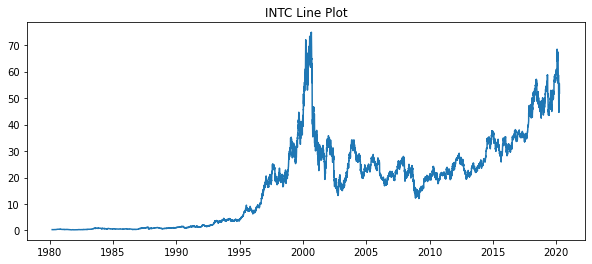

In [135]:
plt.figure(figsize = (10, 4))
plt.plot(INTC_close.index, INTC_close['Close'], linestyle='-')
plt.title("INTC Line Plot")